In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from time import time
from sklearn import preprocessing


plt.rcParams["figure.figsize"] = (20,10)

import warnings
warnings.filterwarnings("ignore")

from platform import python_version
print(python_version())
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

3.10.11


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, f1_score as f1, recall_score


def make_confusion_matrix(cf,
                          true_labels,
                          pred_labels,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(10, 10),
                          cmap='Greys',
                          title=None,
                          name=None,
                          save=False):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    """

    plt.rcParams.update({'font.size': 16})

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for _ in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        precision = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        f1_score = f1(true_labels, pred_labels, average='weighted')

        print(classification_report(true_labels, pred_labels, digits=4))

        stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
            accuracy, precision, recall, f1_score)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
    if save:
        plt.gcf().subplots_adjust(bottom=0.25)
        plt.savefig(name, dpi=300)

In [ ]:
df = pd.read_csv('df.csv')

In [ ]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
df.drop(['Name', 'block','group', 'ECG', 'SGR', 'PPG','length'], axis = 1, inplace = True)

In [ ]:
X = df.drop('emotions', axis = 1)
y = df['emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [ ]:
le = preprocessing.LabelEncoder()

le.fit(y_train)
classes = dict(zip(le.classes_, range(len(le.classes_))))

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
def objective(trial):
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.1, 0.7, 0.03)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    subsample = trial.suggest_discrete_uniform('subsample', 0.05, 1.0, 0.01)
    min_samples_leaf = trial.suggest_discrete_uniform('min_samples_leaf', 0.05, 0.5, 0.01)
    min_samples_split = trial.suggest_discrete_uniform('min_samples_split', 0.05, 1.0, 0.01)


    gbc = GradientBoostingClassifier(subsample=subsample,
                                     min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,
                                     n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     learning_rate=learning_rate,
                                     random_state=0)
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2023-05-29 13:54:58,638] A new study created in memory with name: no-name-96dc2958-f502-465a-9773-241eef429ae0


KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
params = {'learning_rate': 0.19, 'n_estimators': 262, 'max_depth': 11, 'subsample': 0.89, 'min_samples_leaf': 0.08, 'min_samples_split': 0.11}
gbc = GradientBoostingClassifier(**params)

gbc.fit(X_train, y_train)
    
y_pred = gbc.predict(X_test)
    
print(accuracy_score(y_test, y_pred))


0.9878802281368821


In [ ]:
y_test_inv = le.inverse_transform(y_test)
y_pred_inv = le.inverse_transform(y_pred)

              precision    recall  f1-score   support

       anger     1.0000    1.0000    1.0000      1187
        calm     1.0000    1.0000    1.0000      1424
        fear     1.0000    1.0000    1.0000      1036
   happiness     0.9073    0.8893    0.8982       253
     sadness     0.9105    0.9253    0.9179       308

    accuracy                         0.9879      4208
   macro avg     0.9636    0.9629    0.9632      4208
weighted avg     0.9879    0.9879    0.9879      4208



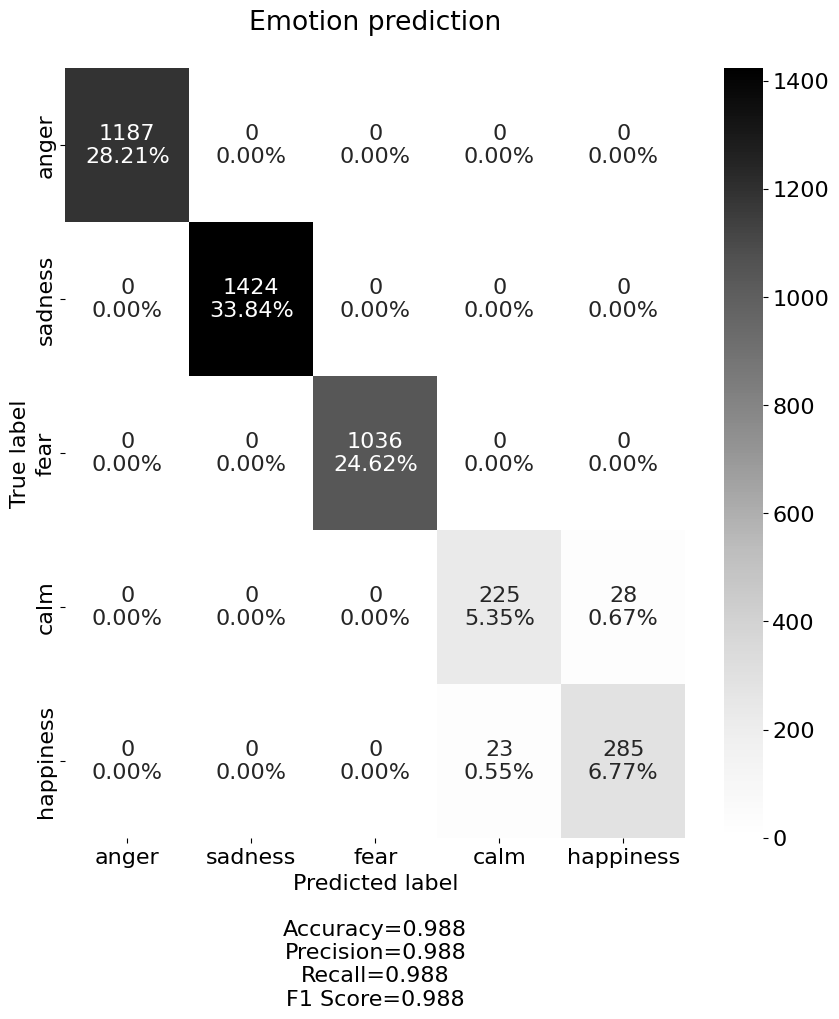

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test_inv, y_pred_inv)
make_confusion_matrix(cf, y_test_inv, y_pred_inv, categories=pd.Series(y_test_inv).unique(),
                          title='Emotion prediction\n', name=f'cf/RandomForestClassifier_500_10.png', save=False)

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred=clf.predict(X_test)

In [ ]:
y_test_inv = le.inverse_transform(y_test)
y_pred_inv = le.inverse_transform(y_pred)

              precision    recall  f1-score   support

       anger     1.0000    1.0000    1.0000      1187
        calm     1.0000    1.0000    1.0000      1424
        fear     1.0000    1.0000    1.0000      1036
   happiness     0.9187    0.8933    0.9058       253
     sadness     0.9143    0.9351    0.9246       308

    accuracy                         0.9888      4208
   macro avg     0.9666    0.9657    0.9661      4208
weighted avg     0.9888    0.9888    0.9888      4208



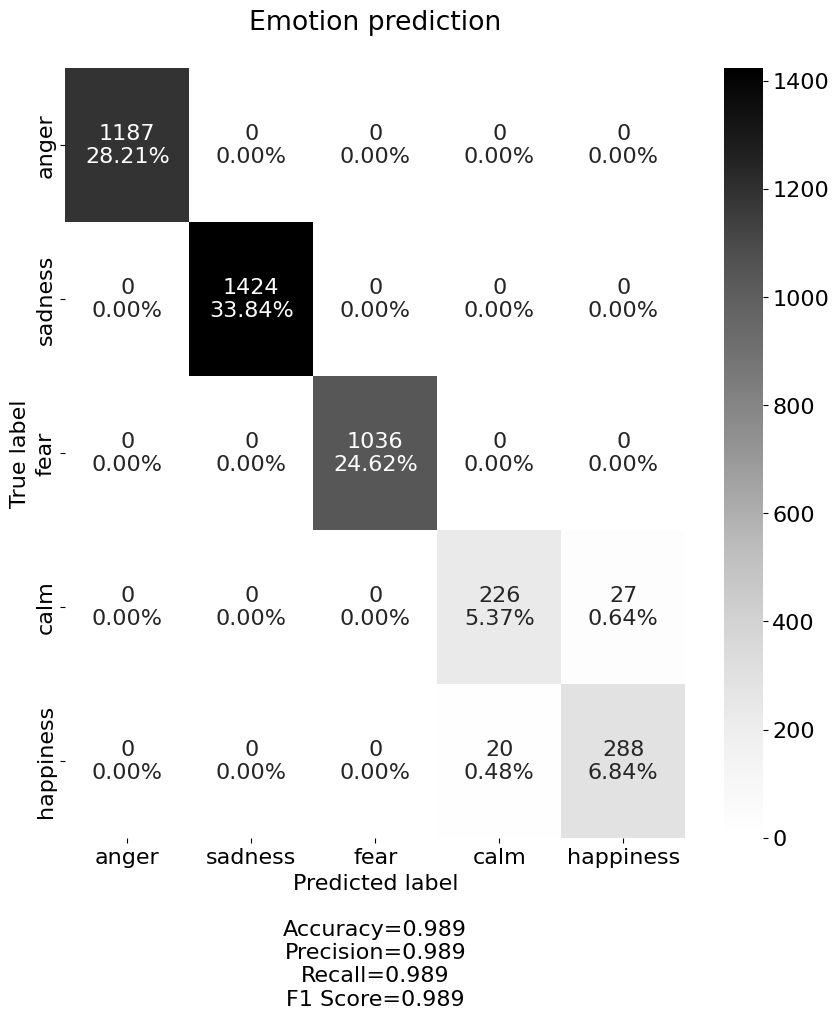

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test_inv, y_pred_inv)
make_confusion_matrix(cf, y_test_inv, y_pred_inv, categories=pd.Series(y_test_inv).unique(),
                          title='Emotion prediction\n', name=f'cf/RandomForestClassifier_500_10.png', save=False)